# Pipeline to predict popularity of a song on spotify based on 2022 data

In [1]:
import sys
sys.path.append(r'C:\Users\bakwe\Documents\GitHub\Git extra\Final_project_Arianna_Vanessa_Tatiana\spotify_library')
import spotify_library 
from spotify_library.features.data_loading import *
from spotify_library.features.data_preprocessing import *
from spotify_library.features.EDA import *
from spotify_library.features.data_splitting import *
from spotify_library.features.feature_engineering import *

In [2]:
# load the spotify data of 2022 as df
df = loaddata(r'C:\Users\bakwe\Documents\GitHub\Git extra\Final_project_Arianna_Vanessa_Tatiana/reduced_spotify_2022.csv')

In [3]:
# check missing values
missing_data = missing_values(data = df).missing_values_table()

Dataframe has 20 columns.
There are 0 columns that have missing values.


In [4]:
# drop unnecessary columns: track_id and Unnamed: 0
df = drop(data = df, columns_to_drop=['track_id', 'Unnamed: 0']).drop_columns()

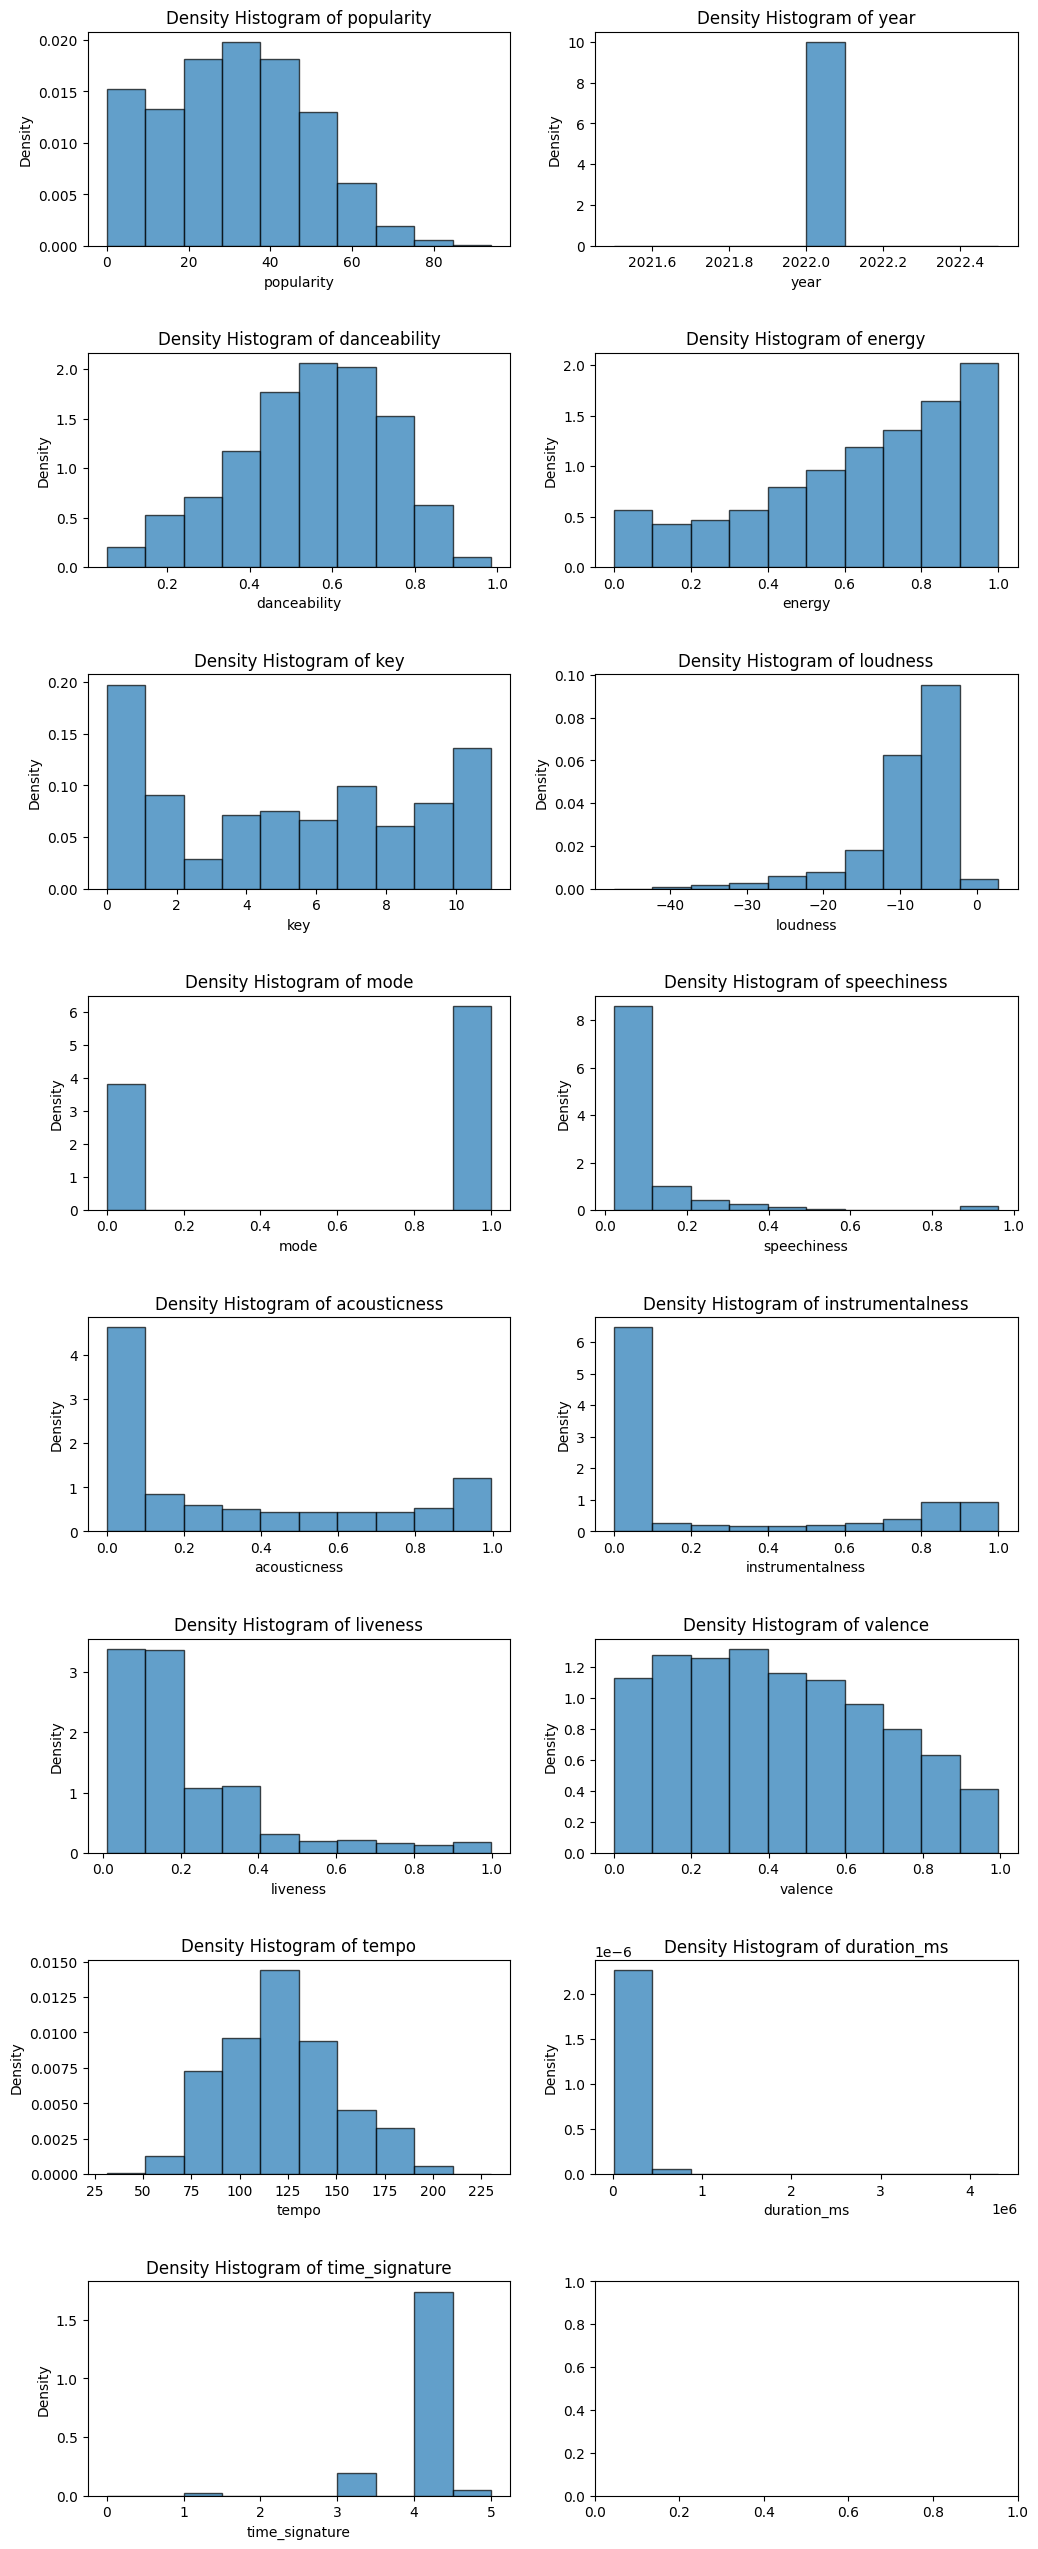

In [5]:
# plot histogram for numerical variables
columns = ['popularity', 'year', 'danceability', 'energy', 'key', 'loudness', 'mode',
           'speechiness', 'acousticness', 'instrumentalness', 'liveness',
           'valence', 'tempo', 'duration_ms', 'time_signature']
hist = hist(df, columns, bins=10, plots_per_row=2).plot_distribution()

In [6]:
# Calculate unique counts for the specified columns
columns = ['track_name', 'artist_name', 'genre']
count = unique_count(df, columns).calculate_unique_counts()

Number of unique values in track_name: 49110
Number of unique values in artist_name: 12779
Number of unique values in genre: 82


In [7]:
# transform column duration_ms to a column where the duration is in minutes
df = transform_columns(df, 'duration_ms').transform_ms_to_minutes()

In [8]:
# # to consider the effect of certain keywords in the trackname on the popularity, binary columns for given keywords are created 
# df = create_binary_columns_for_keywords(df, 'track_name')

In [9]:
# # because of the assumption that popularity is higher when the songs are also played in bars and clubs a variable will be invented: party_music
# df = add_party_music_column(df)